# Random Forest Modeling Coffee Quality Institute Data

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

In [2]:
def read_data(target):
    """Process the csv file and print when complete.
    """
    # Read data from file
    raw = pd.read_csv("../input/cleaned-cqi-arabica-coffee-data/arabica_data_cleaned_update.csv")
    # removing unnecessary field
    raw = raw.drop(columns="ID")
    #removing outlier coffee
    raw = raw.drop([1310])
    #establish field name
    data = raw[['Country', 'Variety', 'Aroma','Flavor','Aftertaste','Acidity','Body','Balance','Uniformity','Clean.Cup','Sweetness','Cupper.Points','Processing.Method','Total.Cup.Points']]
    #check for any null/missing values
    data = data.dropna()
    # DONT FORGET TO RESET YOUR INDEX WHEN YOU REMOVE ROWS!
    data = data.reset_index().drop(columns="index") 
    # we have 1086 rows to work with. get categoricals.
    features = data[['Country', 'Variety', 'Processing.Method']]
    # One-hot encode the data using pandas get_dummies
    features = pd.get_dummies(features)
    # Use numpy to convert to arrays
    # Labels are the values we want to predict
    print('Target:', target)
    labels = np.array(data[target])
    # Saving feature names for later use
    feature_list = list(features.columns)
    # Convert to numpy array
    features = np.array(features)
    # Using Skicit-learn to split data into training and testing sets
    from sklearn.model_selection import train_test_split
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)
    return train_features, test_features, train_labels, test_labels, feature_list
    #print('Training Features Shape:', train_features.shape)
    #print('Training Labels Shape:', train_labels.shape)
    #print('Testing Features Shape:', test_features.shape)
    #print('Testing Labels Shape:', test_labels.shape)
    print('Data Read Successfully.')

def error(predictions, test_l):
    # Calculate the absolute errors
    errors = abs(predictions - test_l)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / test_l)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')
    return round(np.mean(errors),2), accuracy
    
def random_forest(estimators, train_f, train_l, test_f, test_l):
    print('Running Random Forest with {} estimators'.format(estimators))
    # Instantiate model with estimators = 1000 decision trees
    rf = RandomForestRegressor(n_estimators = estimators, random_state = 42)
    # Train the model on training data
    rf.fit(train_f, train_l);
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_f)
    errors = error(predictions, test_l)
    print('Versus simply using the average as a prediction:', )
    base = error(np.mean(test_l), test_l)
    return rf, errors, base

def print_trees(rf, feature_list):
    # Pull out one tree from the forest
    tree = rf.estimators_[5]
    # Export the image to a dot file
    export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
    # Use dot file to create a graph
    (graph, ) = pydot.graph_from_dot_file('tree.dot')
    # Write graph to a png file
    graph.write_png('tree.png')
    # Limit depth of tree to 3 levels for readable tree
    rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
    rf_small.fit(train_features, train_labels)
    # Extract the small tree
    tree_small = rf_small.estimators_[5]
    # Save the tree as a png image
    export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
    (graph, ) = pydot.graph_from_dot_file('small_tree.dot')
    graph.write_png('small_tree.png');

def print_importance(rf, feature_list):
    # Get numerical feature importances
    importances = list(rf.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Code for printing to a file 
    importance = open('importance.txt', 'w')
    # Print out the feature and importances 
    [print('Variable: {:45} Importance: {}'.format(*pair), file = importance) for pair in feature_importances];
    importance.close() 
    return importances

def plot_importance(rf, feature_list):
    # Get numerical feature importances
    importances = list(rf.feature_importances_)
    # Set the style
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(20,13.5))
    # list of x locations for plotting
    x_values = list(range(len(importances)))
    # Make a bar chart
    plt.bar(x_values, importances, orientation = 'vertical')
    # Tick labels for x axis
    plt.xticks(x_values, feature_list, rotation='vertical')
    # Axis labels and title
    plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
    plt.savefig('importance_plot.png', format='png')

def random_forest_most_important(feature_list):
    # Extract the two most important features
    important_indices = [feature_list.index('Country_Mexico'), feature_list.index('Processing.Method_Washed / Wet')]
    train_important = train_features[:, important_indices]
    test_important = test_features[:, important_indices]
    print('Extracted two most important features.')
    return important_indices, train_important, test_important, random_forest(estimators=1000, train_f = train_important, train_l = train_labels, test_f = test_important, test_l = test_labels)

## Random Forest: Total Cup Points

In [3]:
train_features, test_features, train_labels, test_labels , feature_list= read_data('Total.Cup.Points')
rf, errors, base = random_forest(1000, train_features, train_labels, test_features, test_labels)

Target: Total.Cup.Points
Running Random Forest with 1000 estimators
Mean Absolute Error: 1.67 degrees.
Accuracy: 97.94 %.
Versus simply using the average as a prediction:
Mean Absolute Error: 1.69 degrees.
Accuracy: 97.91 %.


## Printing Trees to File and Plotting Importance

In [4]:
print_trees(rf, feature_list)

In [5]:
importances = print_importance(rf, feature_list)

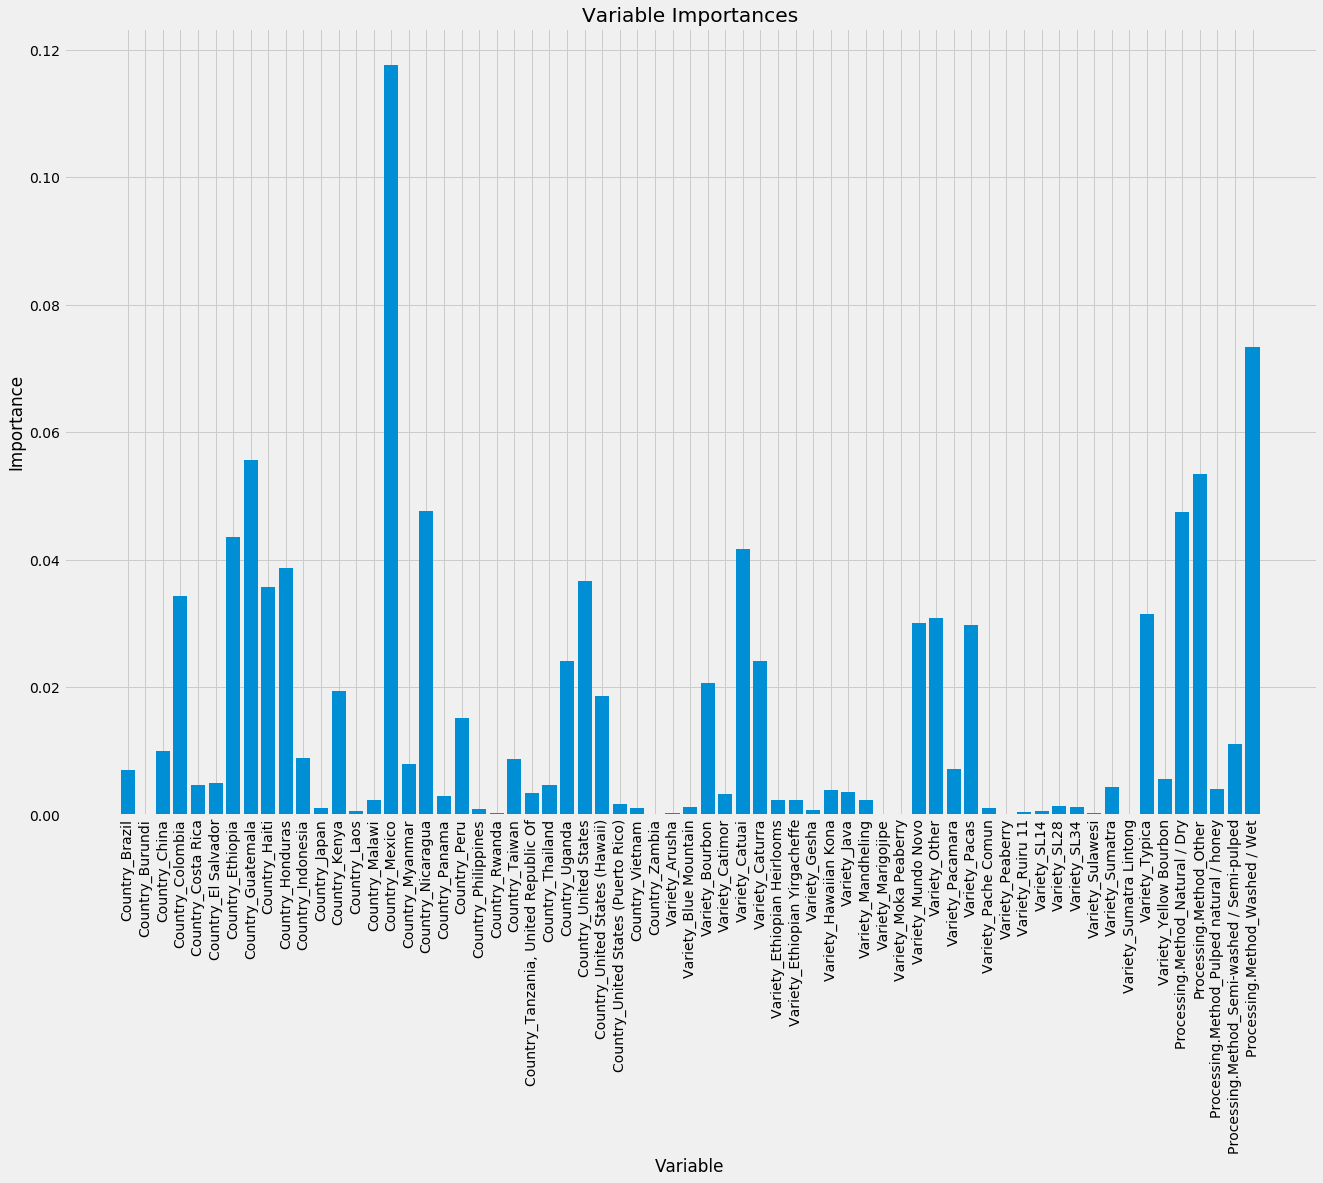

In [6]:
plot_importance(rf, feature_list)

## Redoing model with less features

In [7]:
important_features = ['Country_Mexico', 'Processing.Method_Washed / Wet']
important_indices, train_important, test_important, rf_mi = random_forest_most_important(important_features)

Extracted two most important features.
Running Random Forest with 1000 estimators
Mean Absolute Error: 1.73 degrees.
Accuracy: 97.86 %.
Versus simply using the average as a prediction:
Mean Absolute Error: 1.69 degrees.
Accuracy: 97.91 %.


## Multiple Targets

In [8]:
target_list = ['Aroma','Flavor','Aftertaste','Acidity','Body','Balance','Uniformity','Clean.Cup','Sweetness','Cupper.Points'] 
overview = pd.DataFrame(columns=['target', 'error improvement', 'error', 'base error', 'accuracy', 'base accuracy'])

for t in target_list:
    train_features, test_features, train_labels, test_labels , feature_list= read_data(t);
    rf, errors, base = random_forest(1000, train_features, train_labels, test_features, test_labels);
    overview = overview.append({'target':t, 'error improvement':round(base[0]-errors[0], 2), 'error':errors[0], 'base error':base[0], 'accuracy':errors[1], 'base accuracy': base[1]}, ignore_index=True)

Target: Aroma
Running Random Forest with 1000 estimators
Mean Absolute Error: 0.22 degrees.
Accuracy: 97.09 %.
Versus simply using the average as a prediction:
Mean Absolute Error: 0.23 degrees.
Accuracy: 96.98 %.
Target: Flavor
Running Random Forest with 1000 estimators
Mean Absolute Error: 0.23 degrees.
Accuracy: 96.9 %.
Versus simply using the average as a prediction:
Mean Absolute Error: 0.24 degrees.
Accuracy: 96.78 %.
Target: Aftertaste
Running Random Forest with 1000 estimators
Mean Absolute Error: 0.22 degrees.
Accuracy: 96.93 %.
Versus simply using the average as a prediction:
Mean Absolute Error: 0.25 degrees.
Accuracy: 96.63 %.
Target: Acidity
Running Random Forest with 1000 estimators
Mean Absolute Error: 0.21 degrees.
Accuracy: 97.22 %.
Versus simply using the average as a prediction:
Mean Absolute Error: 0.22 degrees.
Accuracy: 97.05 %.
Target: Body
Running Random Forest with 1000 estimators
Mean Absolute Error: 0.18 degrees.
Accuracy: 97.53 %.
Versus simply using the ave

In [9]:
overview

,target,error improvement,error,base error,accuracy,base accuracy
0,Aroma,0.01,0.22,0.23,97.089632,96.978967
1,Flavor,0.01,0.23,0.24,96.901271,96.777765
2,Aftertaste,0.03,0.22,0.25,96.931947,96.628130
3,Acidity,0.01,0.21,0.22,97.221755,97.048527
4,Body,0.02,0.18,0.20,97.527104,97.315336
5,Balance,0.03,0.23,0.26,96.893984,96.490412
6,Uniformity,0.00,0.23,0.23,97.460271,97.498942
7,Clean.Cup,-0.04,0.28,0.24,96.786602,97.090010
8,Sweetness,-0.05,0.12,0.07,98.809751,99.252985
9,Cupper.Points,0.02,0.26,0.28,96.424762,96.260988


- check for error if we just use the mean as a guess vs random forest
    - It seems that it is just as good of a predictor.
- make error calculator
    - see error()
- look at different targets
    - does not seem to be better than using the average score
- When does PCA break down? report in paper and explain why it changed with removal of numerical data
- "Limitations" section on data